In [2]:
from pathlib import Path
from collections import deque
import cv2
import numpy as np
from typing import NoReturn

In [69]:
from typing import List, Dict, Tuple


def compute_smooth_histogram(image: np.ndarray, smooth_factor: int = 1) -> np.ndarray:
    """
        Calculate and return a smoothed histogram for a given image.
    
        Args:
            image (np.ndarray): Input image as a NumPy array.
            smooth_factor (int): Smoothing factor determines the width of the smoothing window.
    
        Returns:
            np.ndarray: Smoothed histogram as a NumPy array.
        """
    # Calculate the histogram for the image
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Normalize the histogram to the range 0-255
    normalized_histogram = (histogram / histogram.max()) * 255

    # Flatten the histogram array
    flat_histogram = normalized_histogram.flatten()

    # Apply convolution to smooth the histogram
    smoothing_window = np.ones(smooth_factor) / smooth_factor
    smooth_histogram = np.convolve(flat_histogram, smoothing_window, mode='same')

    return smooth_histogram


def find_first_local_minimum(data: np.ndarray) -> int:
    """
        Identify the first local minimum in a 1D array.
    
        This function finds the first local minimum by checking where the value
        of the array drops below the values of its neighbors.
    
        Args:
            data (np.ndarray): The input array for which to find the local minimum.
    
        Returns:
            int: The index of the first local minimum in the array.
    
        Raises:
            ValueError: If no local minimum is found.
        """

    # Calculate differences to find local minima
    local_minima_indices = np.where((data[1:-1] < data[:-2]) & (data[1:-1] < data[2:]))[0]

    if local_minima_indices.size == 0:
        raise ValueError("No local minimum found in the array.")

    # Return the index of the first local minimum
    return local_minima_indices[0]



def calculate_region_centroids(segmented_image: np.ndarray) -> list[list[int]]:
    """
    Calculate the centroids of labeled regions in a segmented image.

    This function computes the centroids of all labeled regions in a binary segmented image,
    excluding the background which is labeled as 0.

    Args:
        segmented_image (np.ndarray): An image array where different regions are labeled with integers.

    Returns:
        list: A list of centroids, where each centroid is represented as [x, y].

    Raises:
        ValueError: If any region has a zero area which would cause division by zero.
    """

    if np.max(segmented_image) == 0:
        raise ValueError("The segmented image contains no objects to process.")

    centroids = []
    
    # Start from 2 as 0 and 1 are typically background and border labels in segmented images
    for label in range(2, np.max(segmented_image) + 1):
        mask = np.zeros_like(segmented_image)
        mask[segmented_image == label] = 1

        # Calculate moments for the current region
        moments = cv2.moments(mask, binaryImage=True)

        # Check for zero area to avoid division by zero
        if moments['m00'] == 0:
            raise ValueError(f"Region with label {label} has zero area, can't compute centroid.")

        # Calculate centroid coordinates
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])

        centroids.append([cx, cy])

    return centroids


def label_image_regions(image):
    """
    Label connected regions in a binary image using breadth-first search (BFS).

    Args:
        image (np.ndarray): A binary image where foreground pixels are 1 and background pixels are 0.

    Returns:
        np.ndarray: An image with labeled regions, where each connected component has a unique integer label.
    """
    rows, cols = image.shape
    visited = np.zeros_like(image, dtype=bool)
    labels = np.zeros_like(image, dtype=int)

    # Directions for moving in the image (right, left, down, up)
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def is_within_bounds(x, y):
        """Check if the coordinates are within the image bounds."""
        return 0 <= x < rows and 0 <= y < cols

    def bfs(start_x, start_y, label):
        """Perform BFS from the start point and label all connected pixels."""
        queue = deque([(start_x, start_y)])
        visited[start_x][start_y] = True
        labels[start_x][start_y] = label

        while queue:
            x, y = queue.popleft()
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if is_within_bounds(nx, ny) and not visited[nx][ny] and image[nx][ny] == 1:
                    queue.append((nx, ny))
                    visited[nx][ny] = True
                    labels[nx][ny] = label

    label_count = 1
    for i in range(rows):
        for j in range(cols):
            if not visited[i][j] and image[i][j] == 1:
                bfs(i, j, label_count)
                label_count += 1

    return labels


def get_region_values(image: np.ndarray, points: List[Tuple[int, int]]) -> List[Dict[str, int]]:
    """
    Extract values based on defined regions in an image. For each point provided, determine
    the region it belongs to and count the number of pixels in that region. Assign a value
    based on the size of the region.

    Args:
    image (np.ndarray): The image array where each value indicates a region.
    points (List[Tuple[int, int]]): List of (x, y) tuples representing points whose regions
                                    are to be evaluated.

    Returns:
    List[Dict[str, Union[Tuple[int, int], int]]]: A list of dictionaries with the center of
                                                  the region and the assigned value.
    """
    region_counts = {}
    values = []

    for x, y in points:
        region_number = image[y, x]
        if region_number not in region_counts:
            region_counts[region_number] = np.sum(image == region_number)
        number_of_pixels = region_counts[region_number]

        value = 5 if number_of_pixels > 4000 else 1
        values.append({
            "center": (x, y),
            "value": value
        })

    return values



In [18]:
import matplotlib.pyplot as plt

def display_results(original_img, green_component, green_histogram, threshold, segmented_img, labeled_regions, centers, region_values) -> NoReturn:
    # Create a figure with a specific size
    fig = plt.figure(figsize=(18, 10))

    # Titles for each subplot
    titles = ['Original Image', 'Green Channel', 'Histogram of Green Channel',
              'Segmentation Result', 'Labeled Regions', 'Centers of Mass', 'Region Values']

    # Images to display
    images = [
        original_img,
        green_component,
        green_histogram,
        segmented_img,
        labeled_regions,
        original_img,
        original_img
    ]

    # Plot settings for each type of subplot
    for i, (img, title) in enumerate(zip(images, titles), 1):
        ax = fig.add_subplot(2, 4, i)
        if title == 'Histogram of Green Channel':
            ax.plot(img)
            ax.axvline(x=threshold, color='red', label=f'Threshold: {threshold}')
            ax.set_xlim([0, 255])
            ax.set_ylim([0, 255])
            ax.legend()
        else:
            cmap = 'gray' if title == 'Green Channel' or title == 'Segmentation Result' else 'jet' if title == 'Labeled Regions' else None
            ax.imshow(img, cmap=cmap)
            if title == 'Centers of Mass':
                ax.scatter([c[0] for c in centers], [c[1] for c in centers], color='red', marker='+')
            elif title == 'Region Values':
                for coin in region_values:
                    ax.text(coin['center'][0], coin['center'][1], str(coin['value']), color='red', fontsize=12, ha='center')

        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

# Call the function with your data
#display_results(_image, g, g_hist, threshold, segmented_image, regions, points, coin_values)


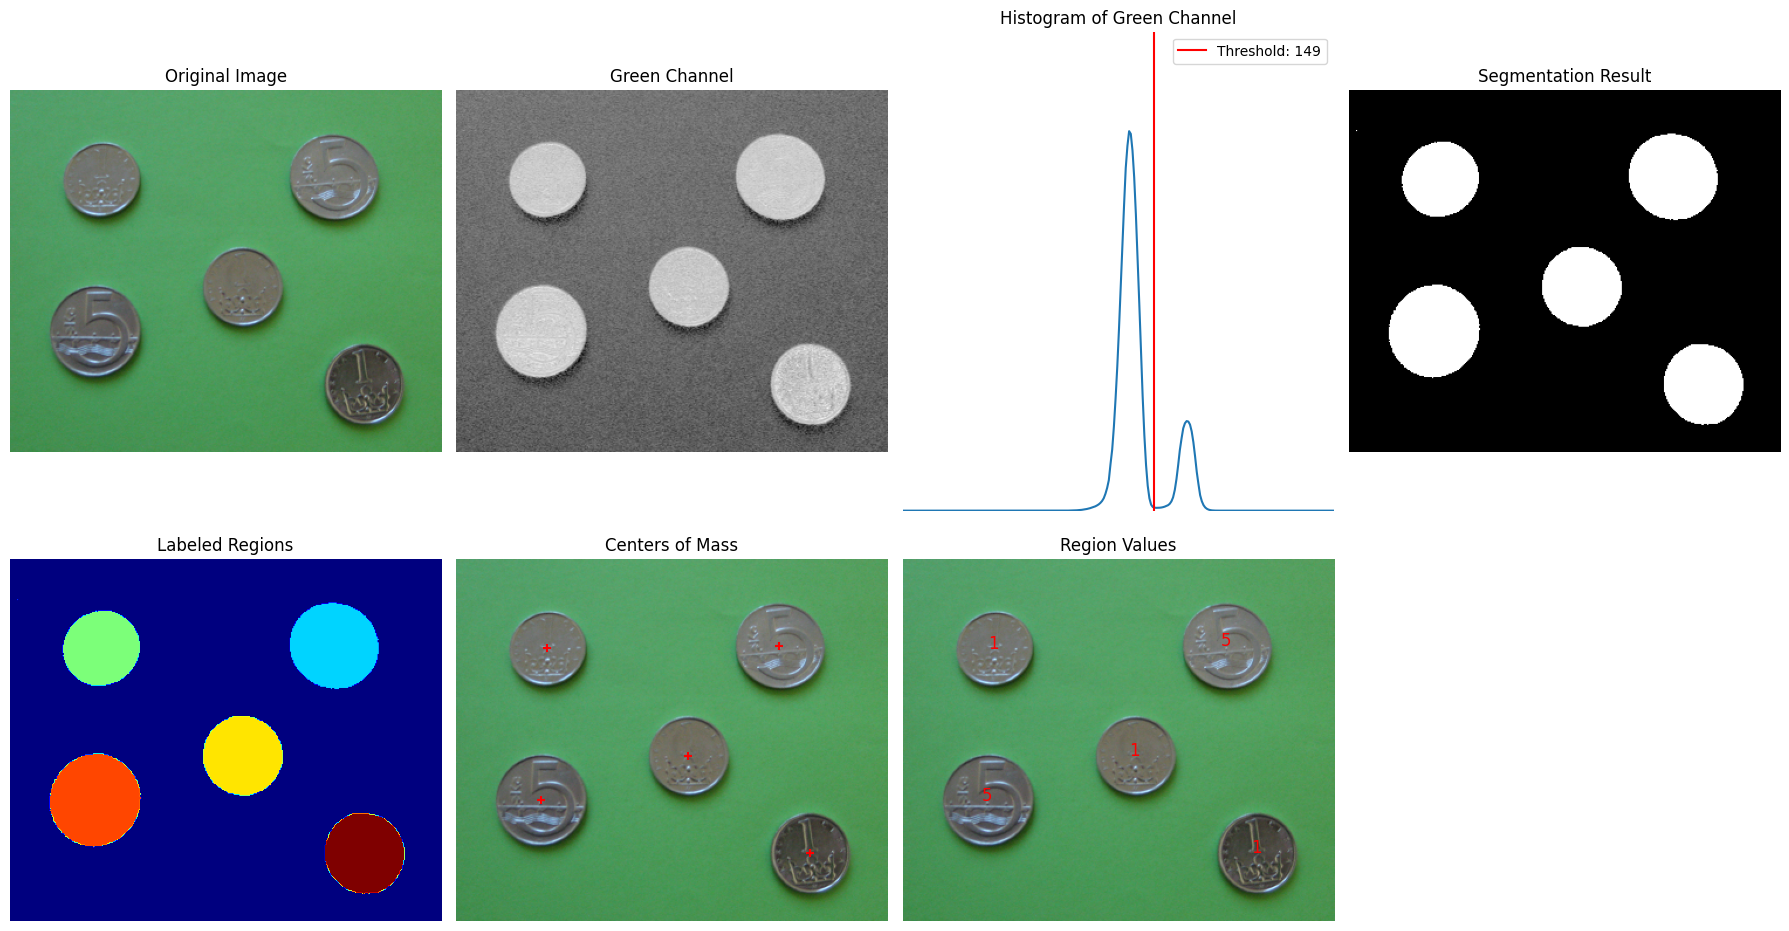

In [70]:
image = cv2.imread(Path("./cv07_segmentace.bmp").as_posix())
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

red = np.float32(image[:, :, 0])
green = np.float32(image[:, :, 1])
blue = np.float32(image[:, :, 2])


g = 255 - ((green * 255) / (red + green + blue))
g_hist = compute_smooth_histogram(g, 10)
threshold = find_first_local_minimum(g_hist)

segmented_image = g.copy()
segmented_image[segmented_image < threshold] = 0
segmented_image[segmented_image >= threshold] = 1

regions = label_image_regions(segmented_image)
points = calculate_region_centroids(regions)
coin_values = get_region_values(regions, points)

display_results(image, g, g_hist, threshold, segmented_image, regions, points, coin_values)